In [180]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
%matplotlib inline
import pathlib

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as pyplot
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [146]:
img_folder = r'/content/gdrive/MyDrive/Colab Notebooks/'
test_folder = pathlib.Path(img_folder + 'test/')
train_folder = pathlib.Path(img_folder + 'train/')
val_folder = pathlib.Path(img_folder + 'val/')


Access the data

In [147]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=SbtTDYhOHZb6

image_count = len(list(train_folder.glob('*/*.jpeg')))
print(image_count)

normal = list(train_folder.glob('NORMAL/*'))
# Image.open(str(normal[0]))

pneu = list(train_folder.glob('PNEUMONIA/*'))
# Image.open(str(pneu[0]))


5216


Create the dataset

In [148]:
batch_size = 32
img_height = 180
img_width = 180


In [149]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [150]:
class_names = train_ds.class_names
print(class_names)


['NORMAL', 'PNEUMONIA']


Visualize

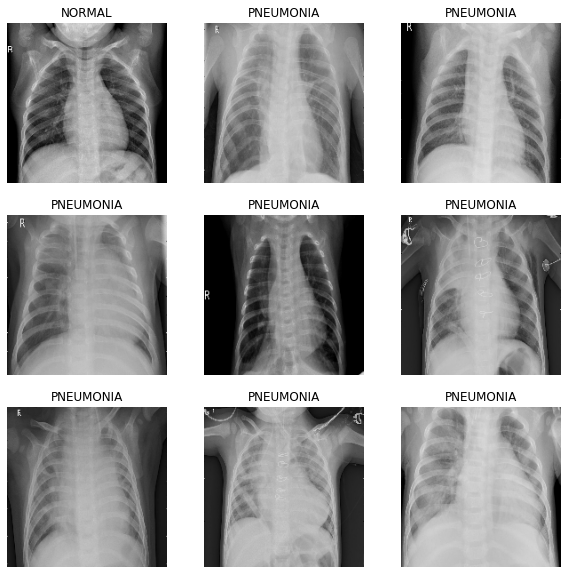

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [152]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(32, 180, 180, 3)
(32,)


Autotune

In [153]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Standardize


In [154]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [155]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0025751335 0.9961046


Create the model

In [156]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [157]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

Train the model


In [158]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
131/131 [==============================] - 127s 964ms/step - loss: 0.2218 - accuracy: 0.9051 - val_loss: 0.1316 - val_accuracy: 0.9645
Epoch 2/10
131/131 [==============================] - 120s 917ms/step - loss: 0.1024 - accuracy: 0.9648 - val_loss: 0.0961 - val_accuracy: 0.9569
Epoch 3/10
131/131 [==============================] - 120s 918ms/step - loss: 0.0817 - accuracy: 0.9705 - val_loss: 0.0698 - val_accuracy: 0.9808
Epoch 4/10
131/131 [==============================] - 118s 903ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 0.0920 - val_accuracy: 0.9674
Epoch 5/10
131/131 [==============================] - 117s 893ms/step - loss: 0.0411 - accuracy: 0.9859 - val_loss: 0.1244 - val_accuracy: 0.9597
Epoch 6/10
131/131 [==============================] - 119s 905ms/step - loss: 0.0325 - accuracy: 0.9859 - val_loss: 0.0870 - val_accuracy: 0.9693
Epoch 7/10
131/131 [==============================] - 119s 906ms/step - loss: 0.0301 - accuracy: 0.9883 - val_loss: 0.0613 -

Visualize the results

We don't see much added value beyond the 6th epoch:

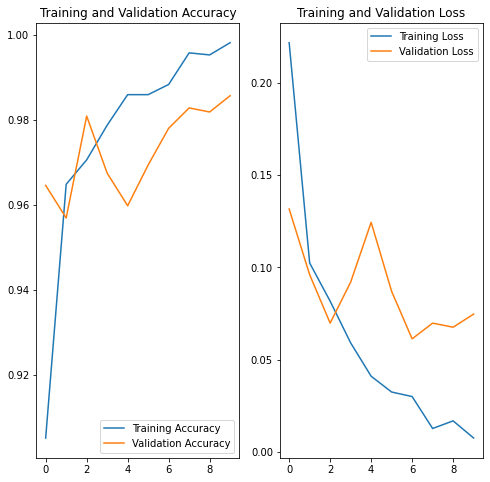

In [159]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Predict






In [175]:
ACTUALS, PREDS = [], []

def get_prediction_accuracy(model, ds):
  results = []
  for images, labels in ds:
    for i in range(len(images)):
      img = images[i].numpy().astype("uint8")
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      prediction = model.predict(img_array)
      score = tf.nn.softmax(prediction[0])

      actual = class_names[labels[i]]
      ACTUALS.append(actual)

      prediction = class_names[np.argmax(score)]
      PREDS.append(prediction)

      conf = 100 * np.max(score)
      print(actual, prediction, f"{conf:.2f}%")
    
      results.append(actual == prediction)

  return results



In [ ]:
results = get_prediction_accuracy(model, test_ds)


In [177]:
accuracy = sum(results) / len(results)
acc_msg = f"Accuracy rate: {round(accuracy * 100, 2)}%"
print(acc_msg)


Accuracy rate: 73.72%


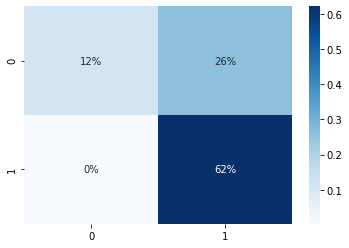

In [181]:
conf = confusion_matrix(ACTUALS, PREDS, labels=class_names)
sns.heatmap(conf/np.sum(conf), annot=True,fmt='.0%', cmap='Blues')
